In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline
sns.set_style('darkgrid')

In [2]:
df = pd.read_csv('AdultDataCleared.csv', index_col=0)

In [3]:
df.head()

,age,workclass,fnlwgt,education,education-num,marital-status,occupation,relationship,race,sex,capital-gain,capital-loss,hours-per-week,native-country,Salary
0,39,State-gov,77516,Bachelors,13,Never-married,Adm-clerical,Not-in-family,White,Male,2174,0,40,United-States,<=50K
1,50,Self-emp-not-inc,83311,Bachelors,13,Married,Exec-managerial,Husband,White,Male,0,0,13,United-States,<=50K
2,38,Private,215646,High School,9,Divorced,Handlers-cleaners,Not-in-family,White,Male,0,0,40,United-States,<=50K
3,53,Private,234721,Compulsory,7,Married,Handlers-cleaners,Husband,Black,Male,0,0,40,United-States,<=50K
4,28,Private,338409,Bachelors,13,Married,Prof-specialty,Wife,Black,Female,0,0,40,Cuba,<=50K


In [4]:
workclass_ = pd.get_dummies(df['workclass'])
marital_ = pd.get_dummies(df['marital-status'])
occupation_ = pd.get_dummies(df['occupation'])
relationship_ = pd.get_dummies(df['relationship'])
race_ = pd.get_dummies(df['race'])
sex_ = pd.get_dummies(df['sex'])
country_ = pd.get_dummies(df['native-country'])
edn_ = pd.get_dummies(df['education'])

In [5]:
for i in [workclass_, marital_, occupation_, relationship_, race_, sex_, country_, edn_]:
    print(i.shape[1])

9
4
14
6
5
2
20
7


In [6]:
X = pd.concat([df[['age','capital-gain', 'hours-per-week']], workclass_ , marital_, occupation_, relationship_, race_, sex_, edn_, country_ ], axis=1)
y = df['Salary']

In [7]:
from sklearn.preprocessing import StandardScaler
std = StandardScaler()
X_temp = X.copy()
X_temp['age'] = std.fit_transform(X_temp[['age']])

In [8]:
from sklearn.decomposition import PCA
pca = PCA(n_components=15)
X_temp = pca.fit_transform(X_temp)

In [9]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X_temp, y, test_size=0.33, random_state=42)
X_train, X_val, y_train, y_val = train_test_split(X_temp, y, test_size=0.05, random_state=42)

In [10]:
from sklearn.neighbors import KNeighborsClassifier

In [28]:
params = {
    'n_neighbors' : [2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15],
    'metric' : ['minkowski', 'manhattan','euclidean']
}

In [29]:
from sklearn.model_selection import GridSearchCV

In [30]:
knn = KNeighborsClassifier()
rv = GridSearchCV(knn, params, n_jobs=1, cv=3, verbose=1)

In [31]:
rv.fit(X_train, y_train)

Fitting 3 folds for each of 42 candidates, totalling 126 fits


GridSearchCV(cv=3, estimator=KNeighborsClassifier(), n_jobs=1,
             param_grid={'metric': ['minkowski', 'manhattan', 'euclidean'],
                         'n_neighbors': [2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13,
                                         14, 15]},
             verbose=1)

In [32]:
rv.best_params_

{'metric': 'minkowski', 'n_neighbors': 15}

In [33]:
rv.best_score_

0.8468899852793449

In [20]:
rv.best_params_

{'metric': 'manhattan', 'n_neighbors': 12}

In [21]:
rv.best_score_

0.8472133538659404

In [34]:
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
pred_ada = rv.predict(X_test)
print(confusion_matrix(y_test, pred_ada), "\n")
print(classification_report(y_test, pred_ada), "\n")
print(accuracy_score(y_test, pred_ada))

[[7664  532]
 [ 942 1608]] 

              precision    recall  f1-score   support

       <=50K       0.89      0.94      0.91      8196
        >50K       0.75      0.63      0.69      2550

    accuracy                           0.86     10746
   macro avg       0.82      0.78      0.80     10746
weighted avg       0.86      0.86      0.86     10746
 

0.8628326819281593


In [35]:
from joblib import load, dump

In [36]:
dump(rv, 'KNNModel.joblib')

['KNNModel.joblib']

In [37]:
from sklearn.metrics import roc_auc_score, roc_curve, plot_roc_curve, auc

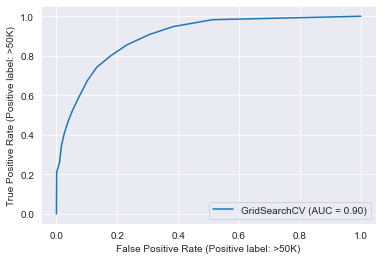

In [38]:
plot_roc_curve(rv, X_val, y_val)

In [39]:
y_true = np.where(y_test==">50K", 1, 0)
y_score = np.where(pred_ada==">50K", 1, 0)

In [40]:
roc_auc_score(y_true, y_score)

0.7828392616197285

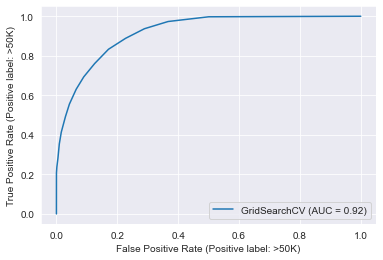

In [41]:
plot_roc_curve(rv, X_test, y_test)

In [42]:
n_classes = 2

fpr = dict()
tpr = dict()
roc_auc = dict()
for i in range(n_classes):
    fpr[i], tpr[i], _ = roc_curve(y_true==i, y_score==i)
    roc_auc[i] = auc(fpr[i], tpr[i])

# Compute micro-average ROC curve and ROC area
fpr["micro"], tpr["micro"], _ = roc_curve(y_true.ravel(), y_score.ravel())
roc_auc["micro"] = auc(fpr["micro"], tpr["micro"])

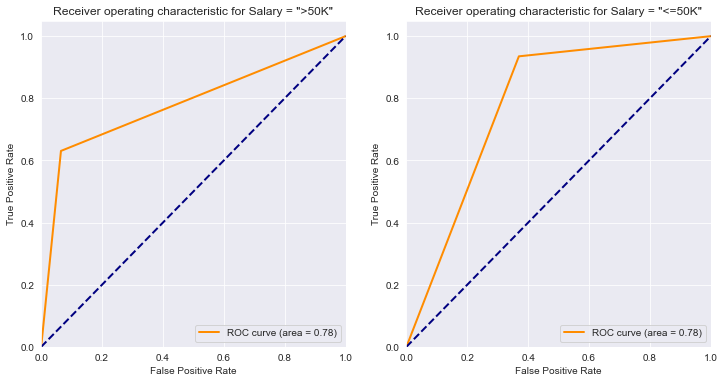

In [45]:
plt.figure(figsize=(12,6))
lw = 2

plt.subplot(1,2,1)
plt.plot(fpr[1], tpr[1], color='darkorange',
         lw=lw, label='ROC curve (area = %0.2f)' % roc_auc[1])
plt.plot([0, 1], [0, 1], color='navy', lw=lw, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic for Salary = ">50K"')
plt.legend(loc="lower right")

plt.subplot(1,2,2)
plt.plot(fpr[0], tpr[0], color='darkorange',
         lw=lw, label='ROC curve (area = %0.2f)' % roc_auc[0])
plt.plot([0, 1], [0, 1], color='navy', lw=lw, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic for Salary = "<=50K"')
plt.legend(loc="lower right")


plt.show()